### Wavelet analysis for NOAA ssh data

Series: Jan-Aug 2016

In [1]:
# We begin by importing the relevant libraries. Please make sure that PyCWT is
# properly installed in your system.
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pycwt as wavelet
from pycwt.helpers import find

# My additional imports
import cmocean as cmo
import datetime as dt
from matplotlib.dates import date2num
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import os
import ssh_tools as ssht # my module
import tide_tools as tidet # my module
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

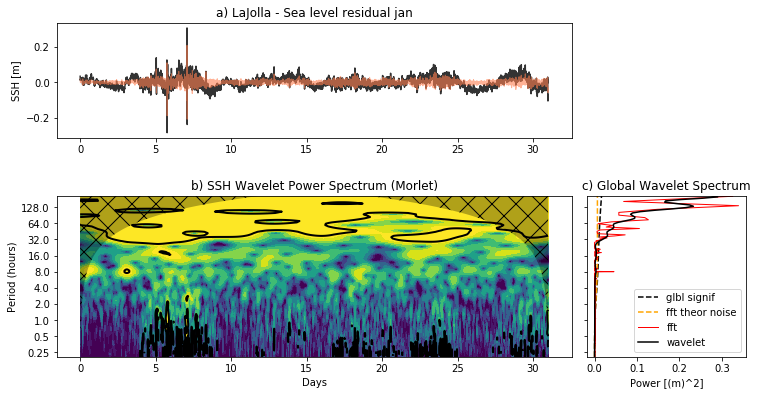

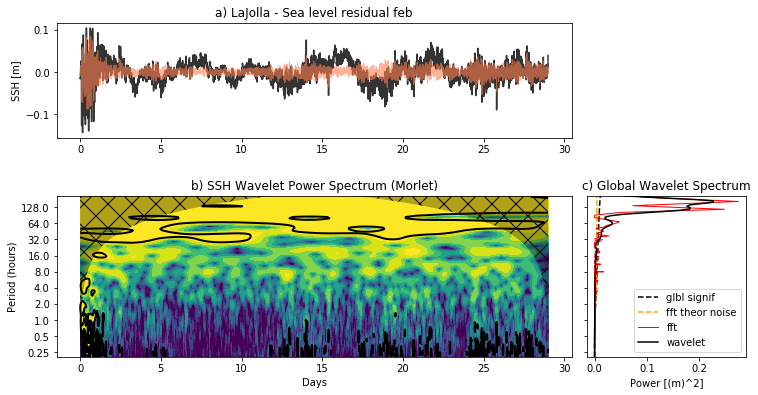

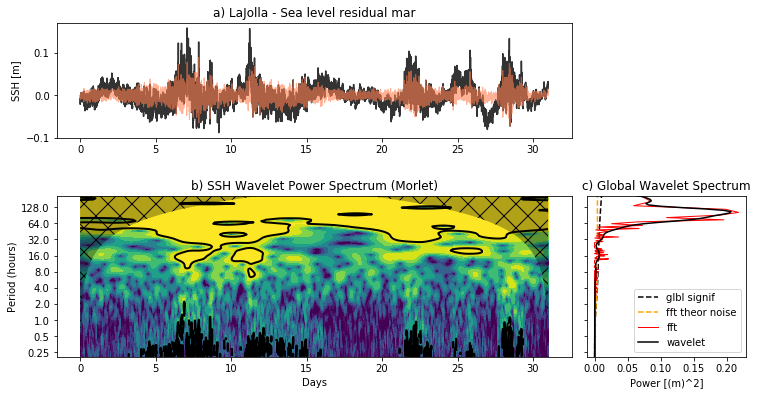

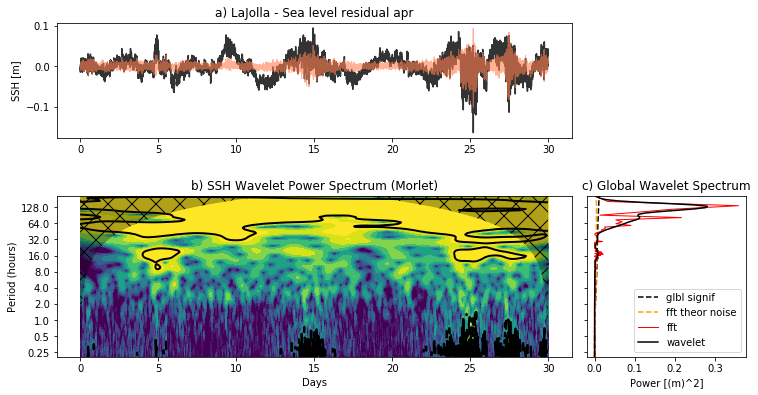

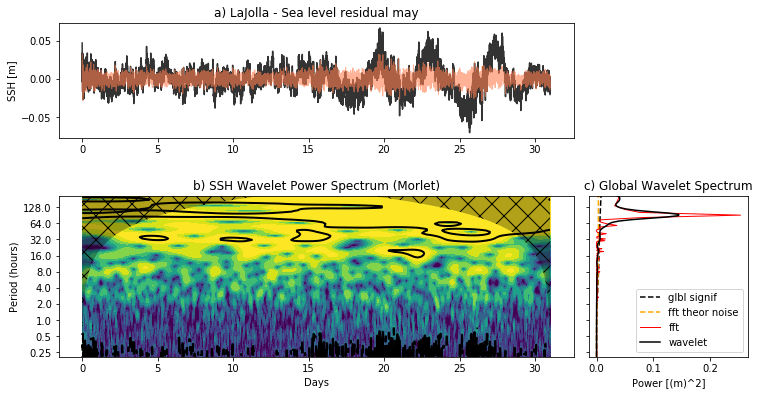

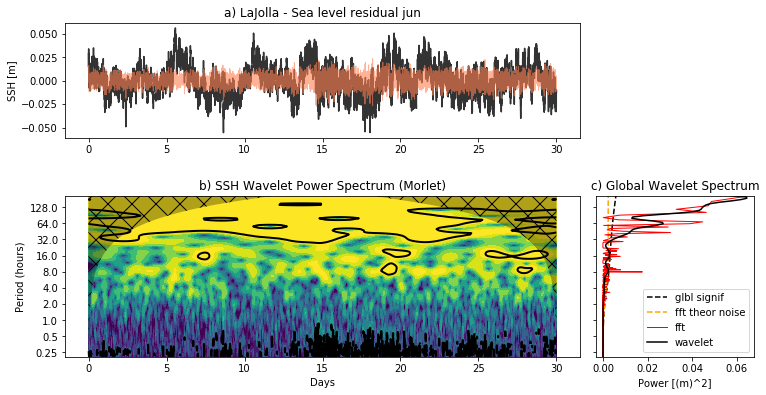

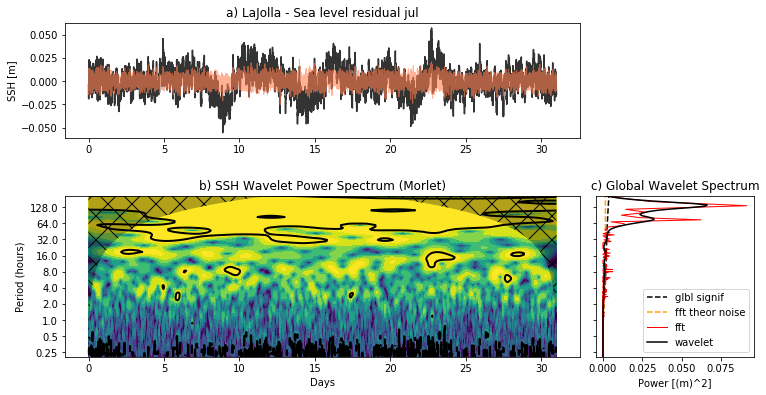

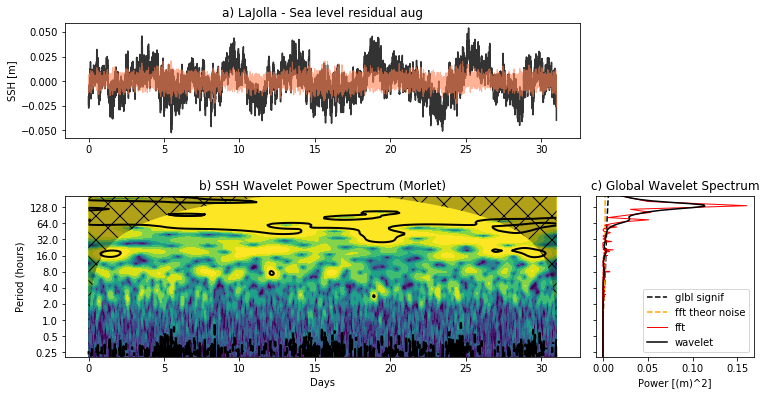

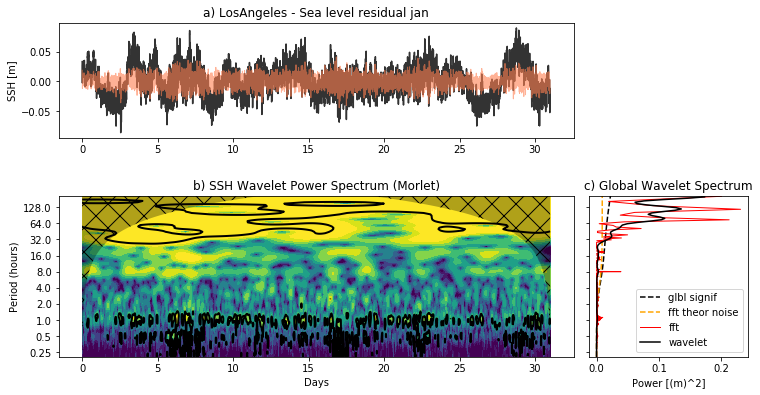

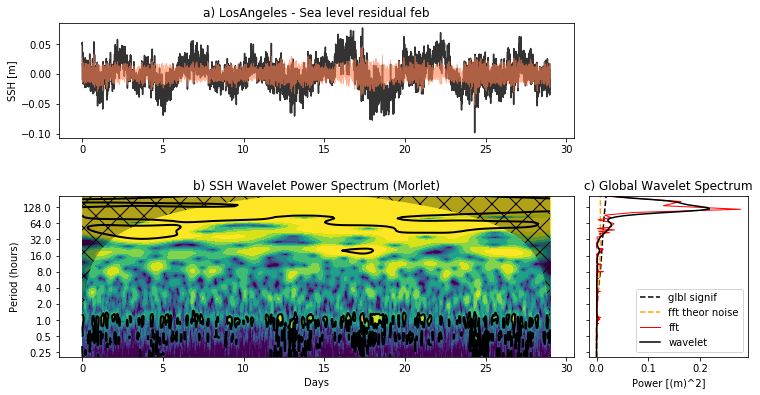

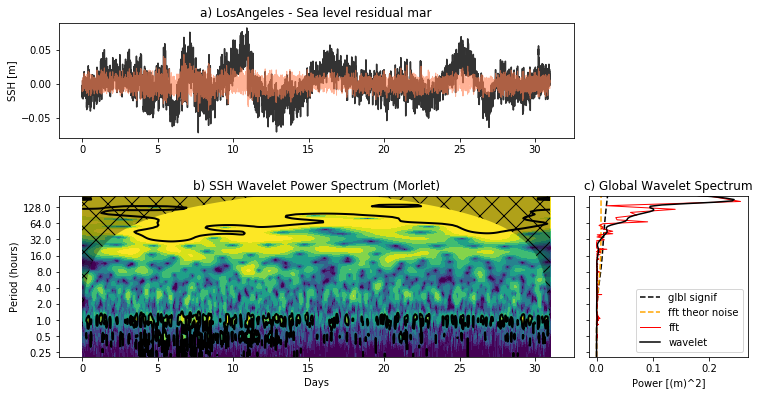

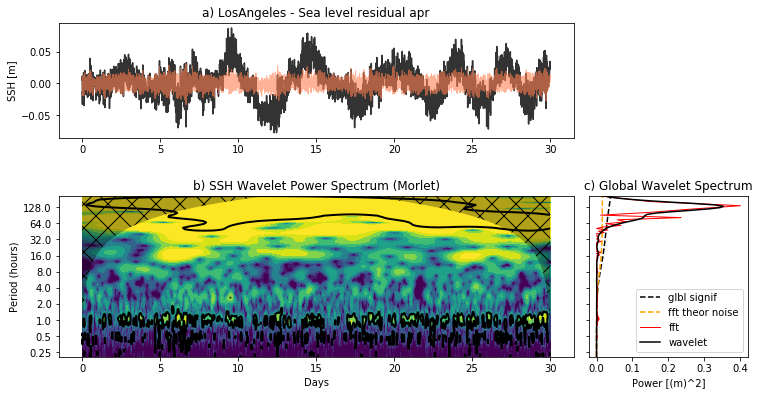

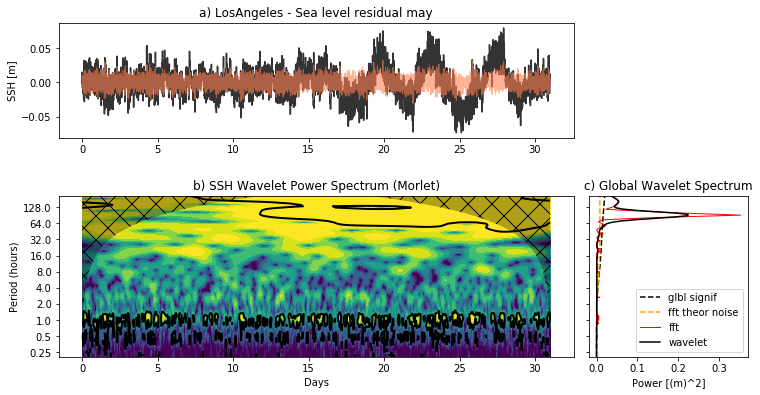

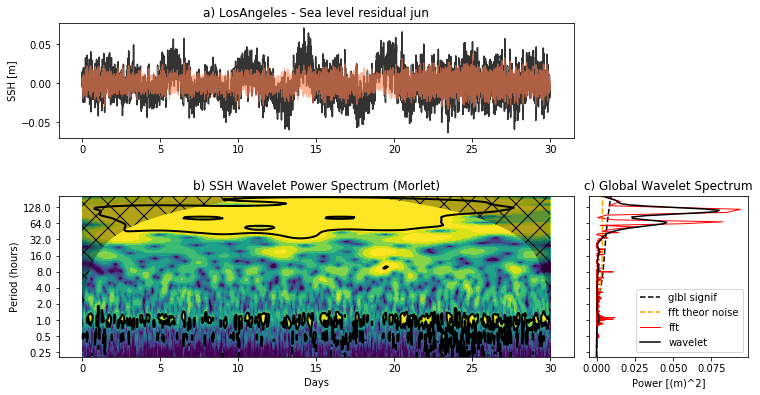

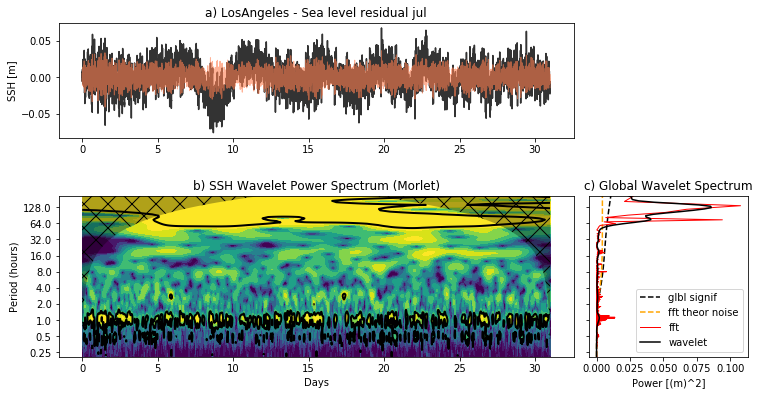

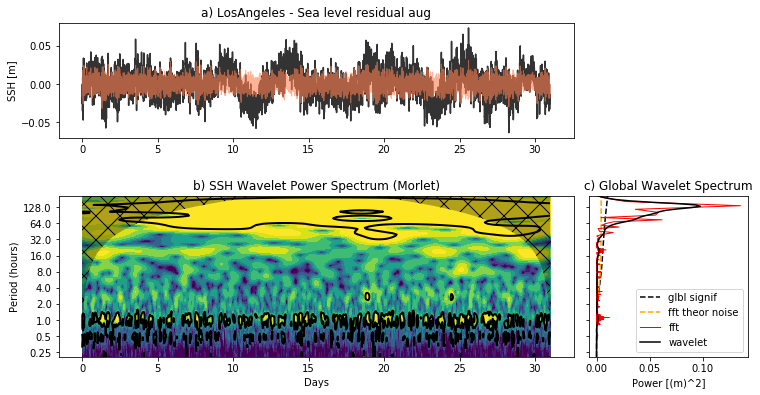

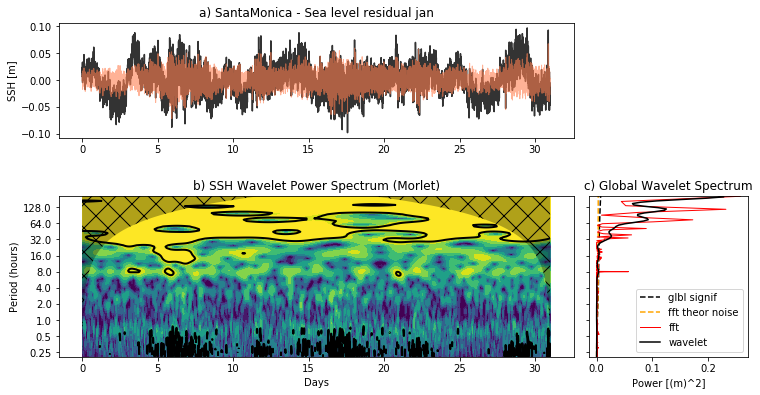

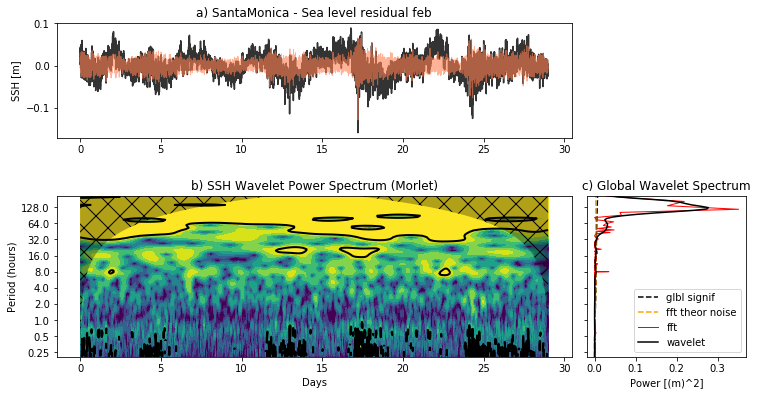

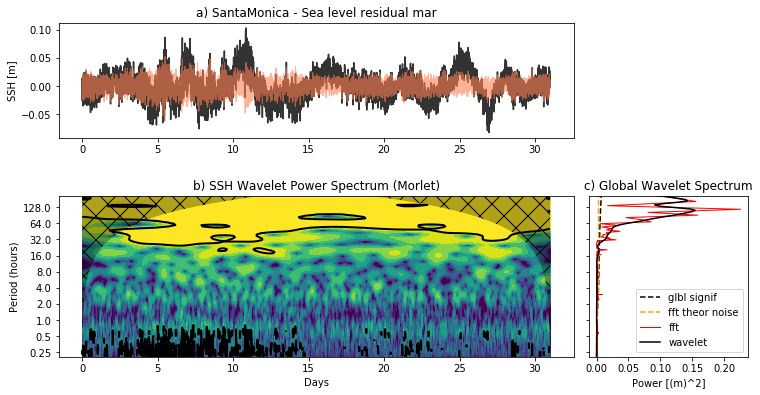

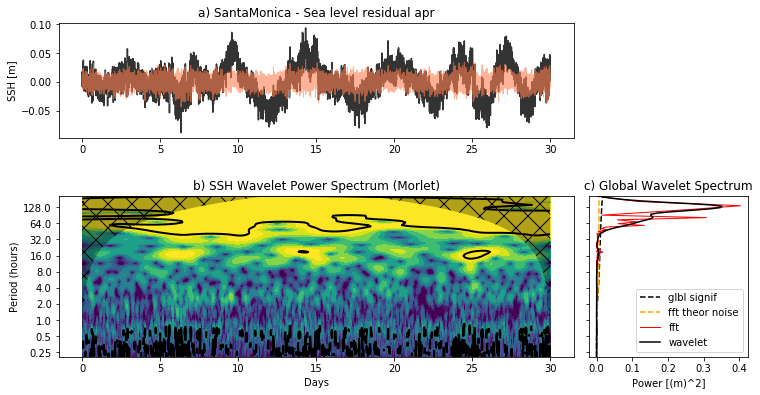

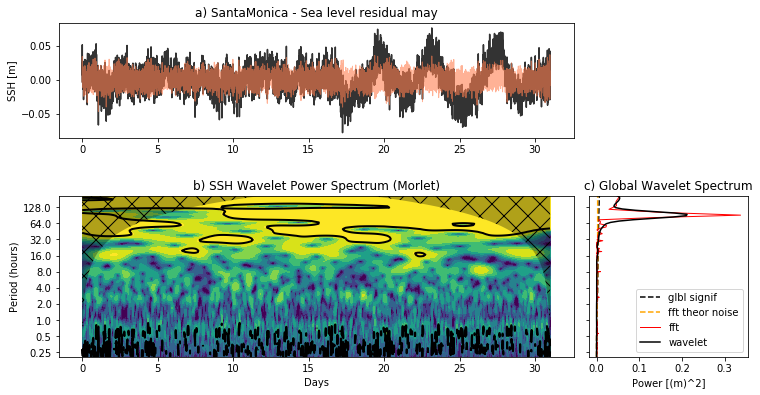

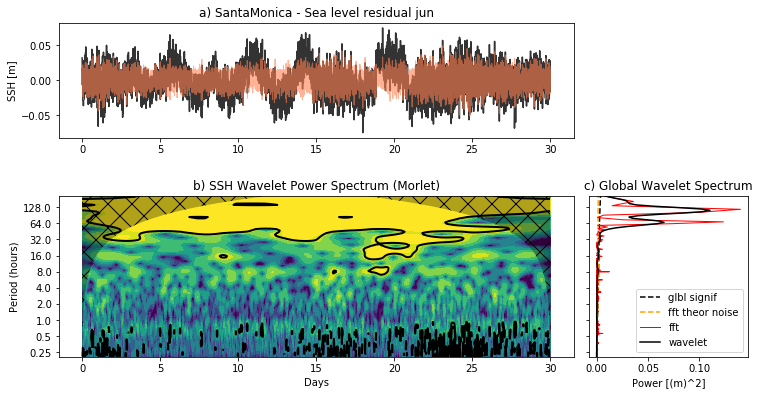

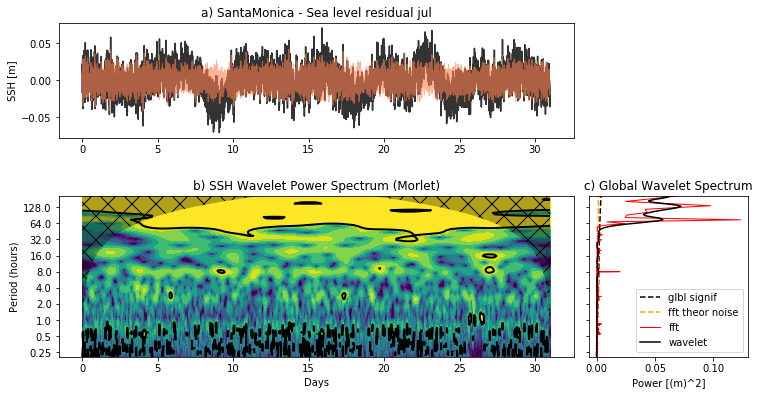

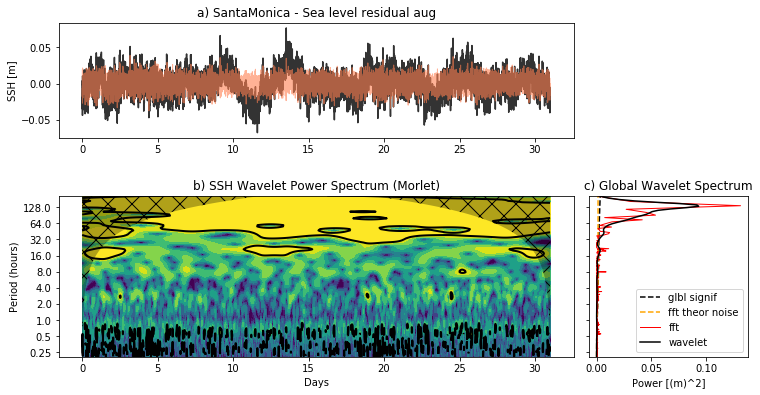

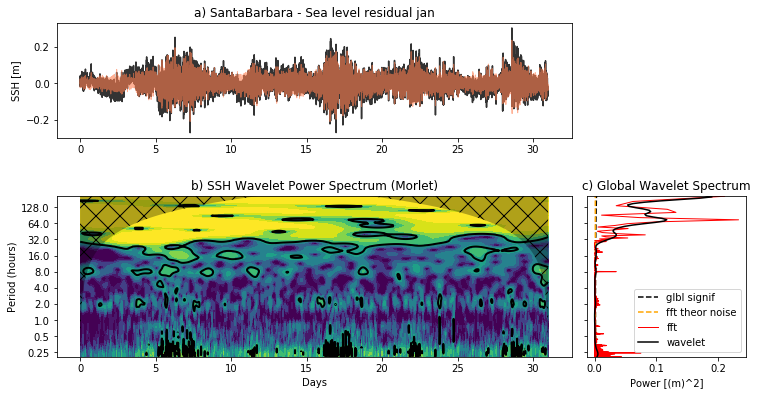

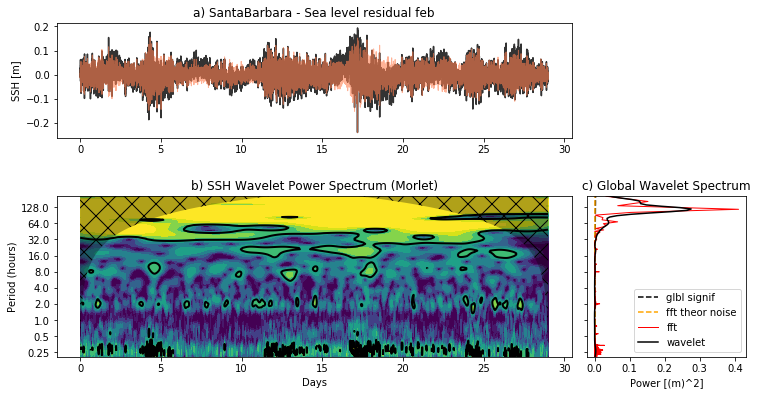

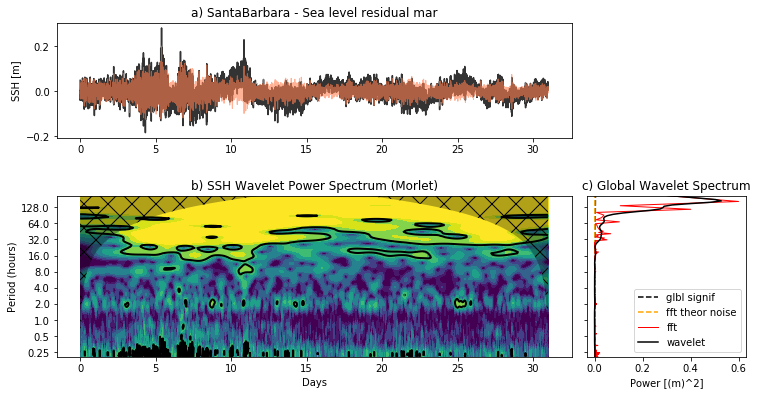

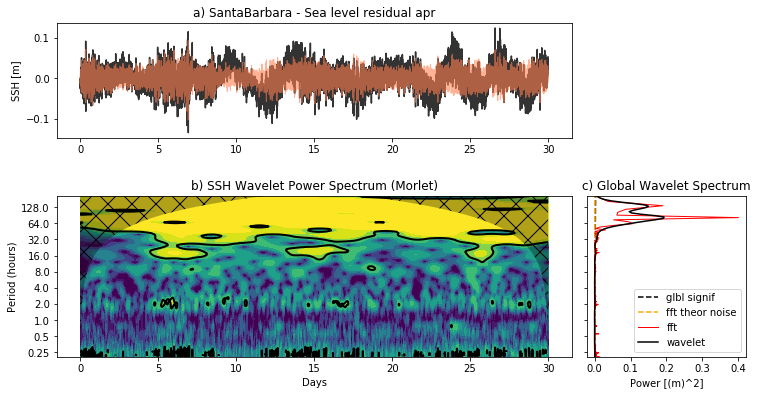

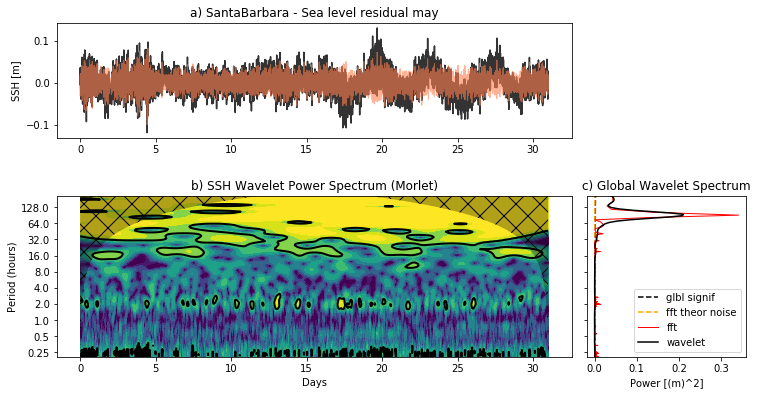

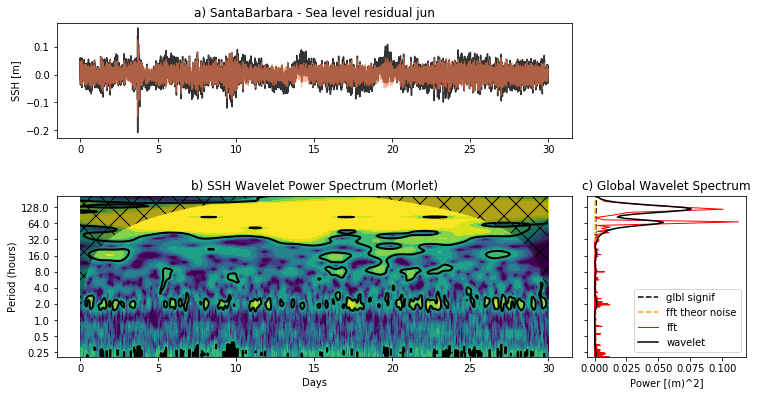

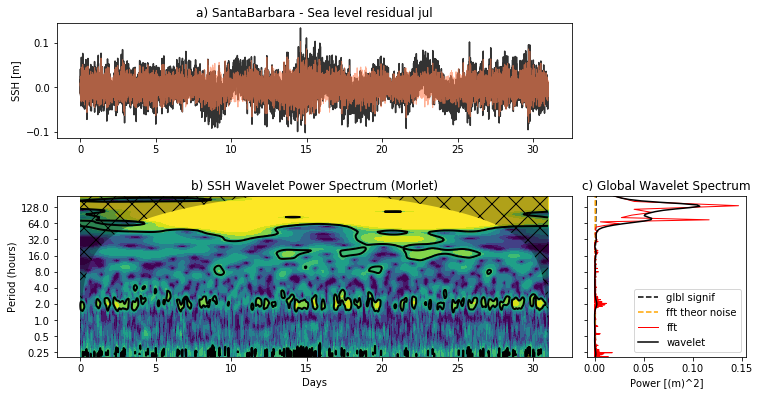

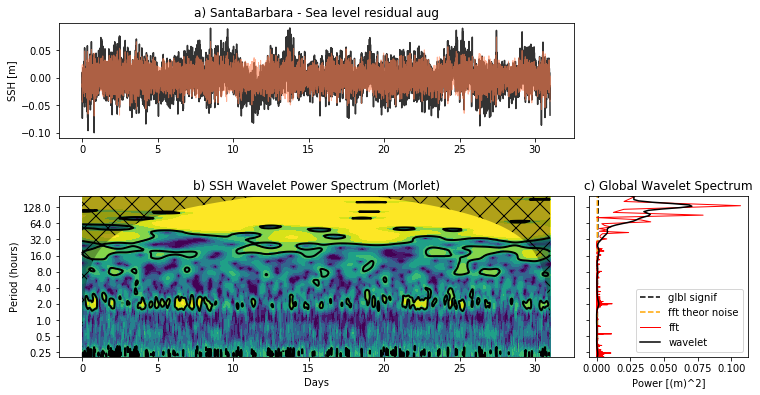

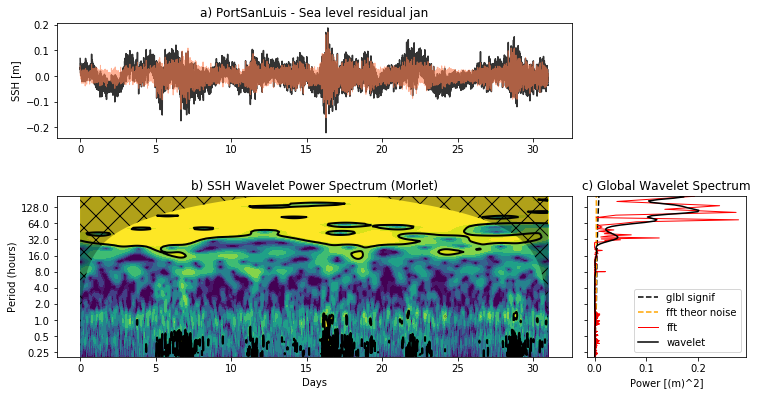

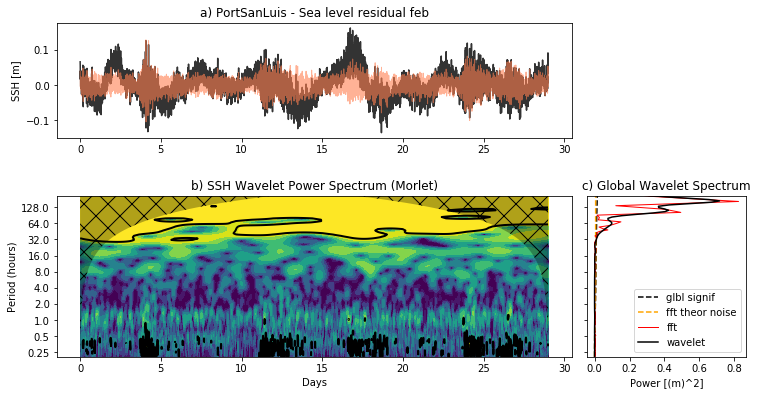

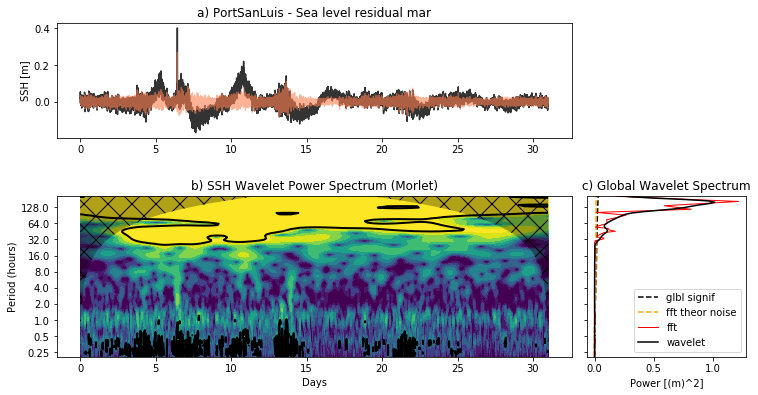

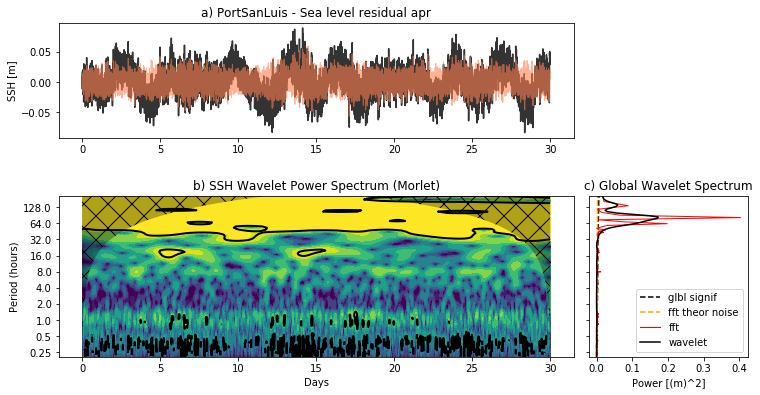

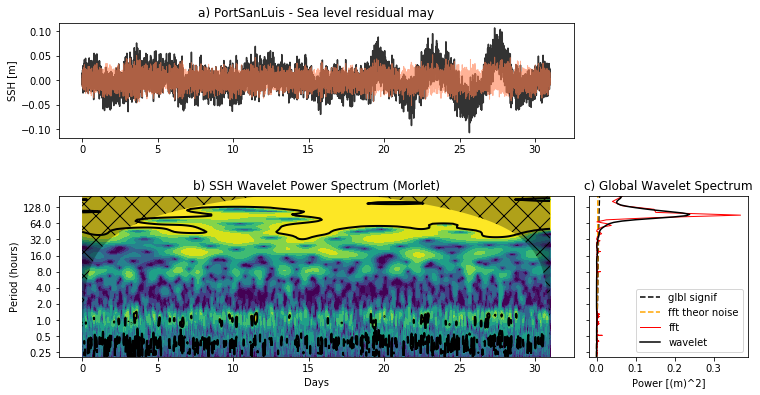

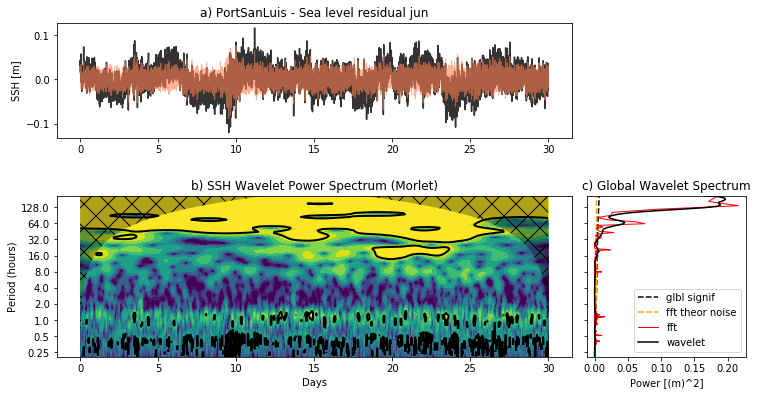

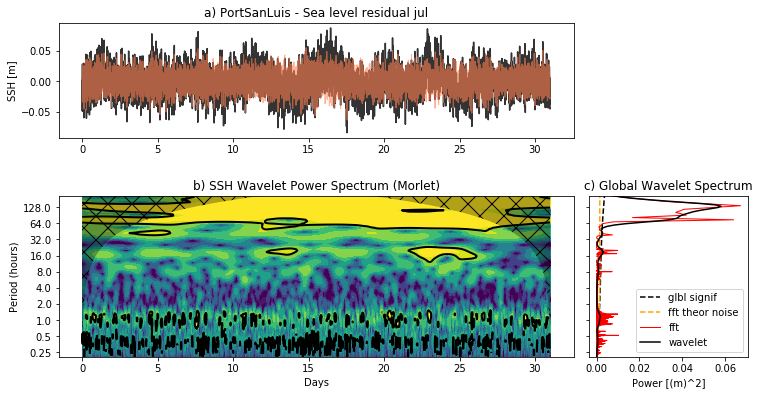

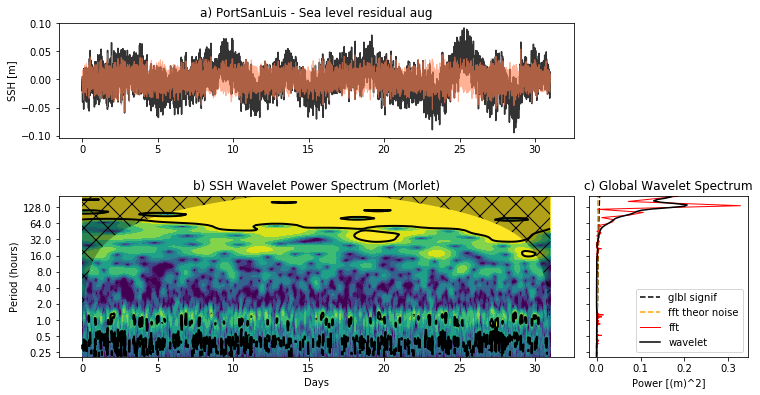

In [2]:
col_names = ["Date","Time","Predicted","Preliminary","Verified"]
stations=['LaJolla','LosAngeles','SantaMonica','SantaBarbara','PortSanLuis']
st_ids = ['9410230','9410660','9410840','9411340','9412110']
months = ['jan','feb','mar','apr','may','jun','jul','aug']
label = 'SSH'
units = 'm'
dt = 0.1  # in hours

omegas = tidet.define_constituents()

for station, st_id in zip(stations, st_ids):
    for month in (months):
        title = '%s - Sea level residual %s' %(station,month)

        # read data
        directory = '../NOAA-seaLevel/' + station 
        filename = directory + '/CO-OPS_' + st_id + '_met_' + month + '.csv'
        data = pd.read_csv(filename, parse_dates=[['Date', 'Time']], names=col_names) 
        data['datetime'] = pd.to_datetime(data['Date_Time'][1:], format='%Y/%m/%d %H:%M')
        data_new = data.set_index('datetime')
        ssh = pd.to_numeric(data_new['Verified'], errors='coerce')
 
        # Time vector of seconds (generate timedelta vector and convert to seconds)
        T = (data['datetime'][1:]-data['datetime'][1])/ np.timedelta64(1, 's')
        T[1] = 1
        A, level = tidet.fit_harmonics(omegas, T, ssh[1:])

        t = (1/3600)*(T.copy())
        dat = ssh.values[1:]-np.squeeze(level)
        dat_notrend = dat - np.nanmean(dat)
        std = np.std(dat_notrend)
        var = std**2
        dat_norm = dat_notrend / std # Normalized dataset
        N = len(dat_norm.values)
        
        mother = wavelet.Morlet(6) 
        s0 = 2 * dt  # Starting scale, in this case 2 * 0.1 hr = 12 min
        dj = 1 / 12  # Twelve sub-octaves per octaves
        J = 10 / dj  # Eleven powers of two with dj sub-octaves
        alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise
    
        wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm.values, dt, dj, s0, J,
                                                      mother)
        iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
        
        power = (np.abs(wave)) ** 2
        fft_power = np.abs(fft) ** 2
        period = 1 / freqs
        
        signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
        sig95 = np.ones([1, N]) * signif[:, None]
        sig95 = power / sig95

        glbl_power = power.mean(axis=1)
        dof = N - scales  # Correction for padding at edges
        glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                                significance_level=0.95, dof=dof,
                                                wavelet=mother)
        
        ## PLOT
        # Prepare the figure
        plt.close('all')
        plt.ioff()
        figprops = dict(figsize=(11, 8), dpi=72)
        fig = plt.figure(**figprops)

        # First sub-plot, the original time series anomaly and inverse wavelet
        # transform.
        ax = plt.axes([0.1, 0.75, 0.65, 0.2])
        ax.plot(t/(24), dat, 'k', linewidth=1.5, alpha=0.8)
        ax.plot(t/(24), iwave, '-', linewidth=1, color='coral', alpha=0.6)
        ax.set_title('a) {}'.format(title))
        ax.set_ylabel(r'{} [{}]'.format(label, units))

        # Second sub-plot, the normalized wavelet power spectrum and significance
        # level contour lines and cone of influece hatched area. Note that period
        # scale is logarithmic.
        bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
        levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
        bx.contourf(t/(24), np.log2(period), np.log2(power), np.log2(levels),
                    extend='both', cmap=plt.cm.viridis)
        extent = [t.min(), t.max(), 0, max(period)]
        bx.contour(t/(24), np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
                   extent=extent)
        bx.fill(np.concatenate([t/(24), t[-1:]/(24) + dt/(24), t[-1:]/(24) + dt/(24),
                                   t[:1]/(24) - dt/(24), t[:1]/(24) - dt/(24)]),
                np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                   np.log2(period[-1:]), [1e-9]]),
                'k', alpha=0.3, hatch='x')
        bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
        bx.set_ylabel('Period (hours)')
        #
        Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                   np.ceil(np.log2(period.max())))
        bx.set_yticks(np.log2(Yticks))
        bx.set_yticklabels(Yticks)
        bx.set_xlabel('Days')
        
        # Third sub-plot, the global wavelet and Fourier power spectra and theoretical
        # noise spectra. Note that period scale is logarithmic.
        cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
        cx.plot(glbl_signif, np.log2(period), 'k--', label='glbl signif')
        cx.plot(var * fft_theor, np.log2(period), '--', color='orange',label='fft theor noise')
        cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='red', label='fft',
                linewidth=1.)
        cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5, label = 'wavelet')
        cx.set_title('c) Global Wavelet Spectrum')
        cx.set_xlabel(r'Power [({})^2]'.format(units))
        #cx.set_xlim([0, glbl_power.max() + var])
        cx.set_ylim(np.log2([period.min(), period.max()]))
        cx.set_yticks(np.log2(Yticks))
        cx.set_yticklabels(Yticks)
        cx.legend()
        plt.setp(cx.get_yticklabels(), visible=False)

        plt.show()

### Time series With tides

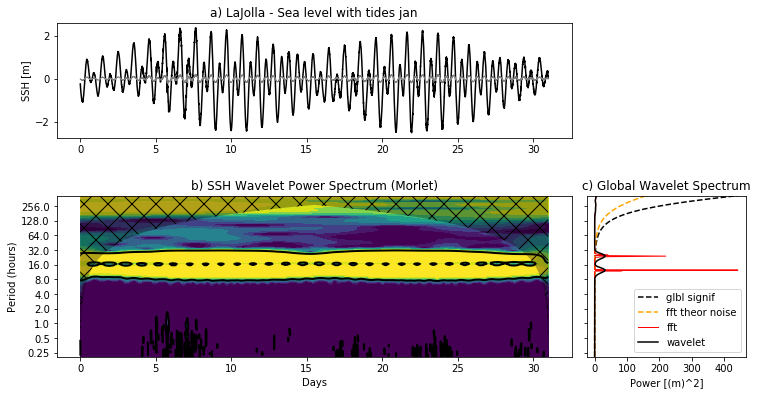

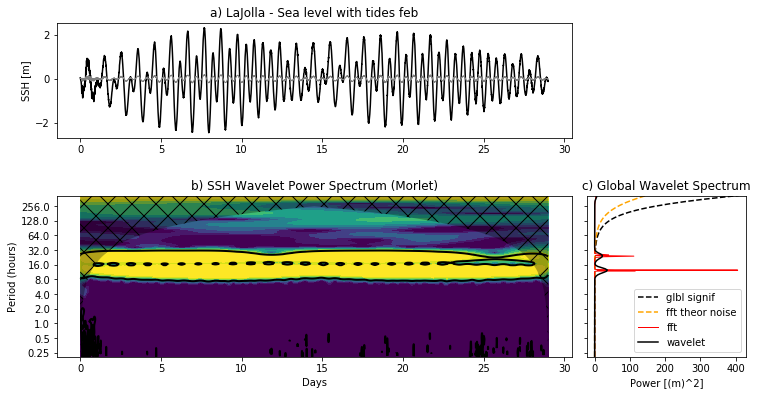

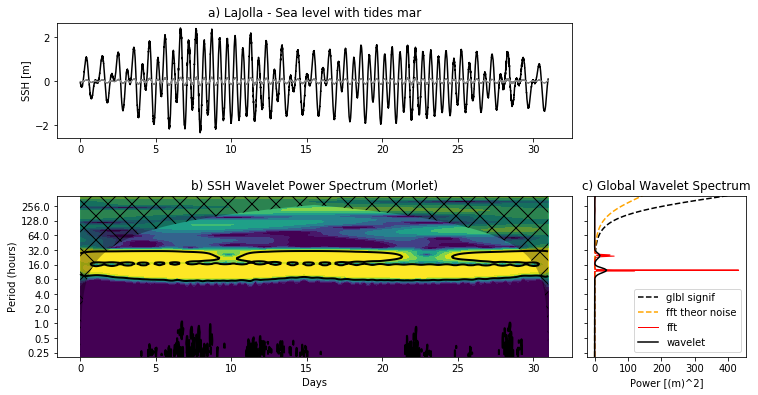

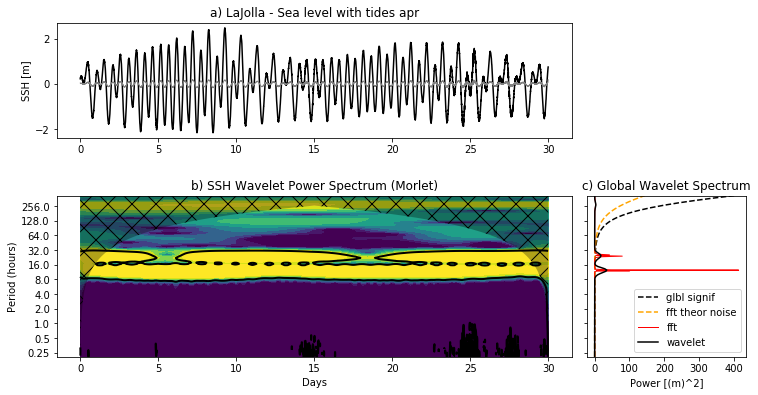

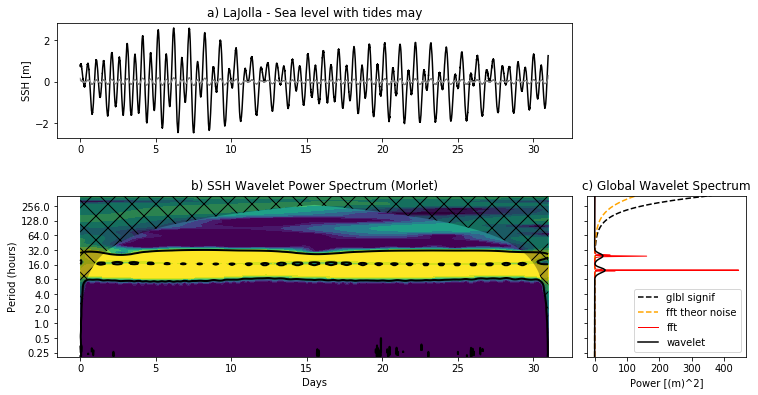

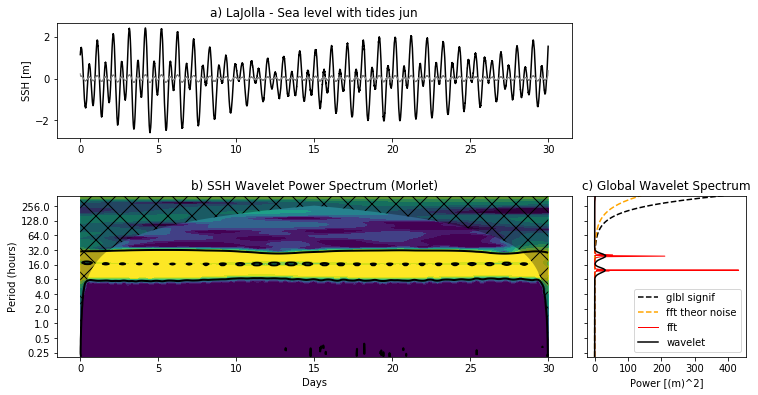

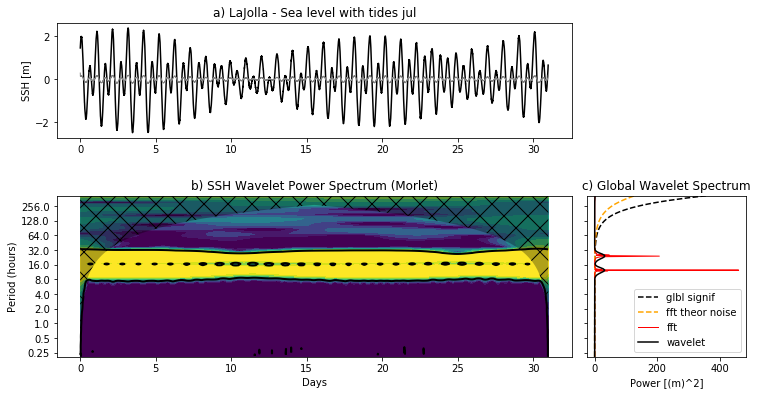

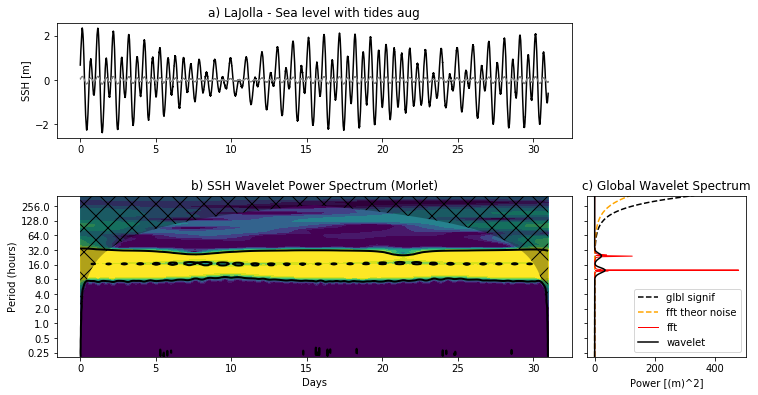

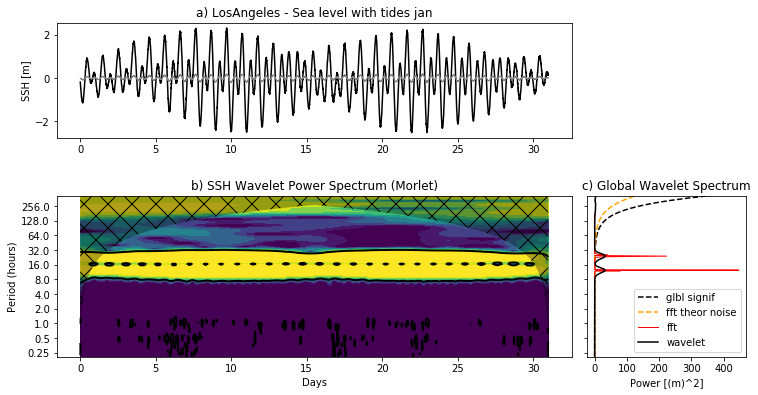

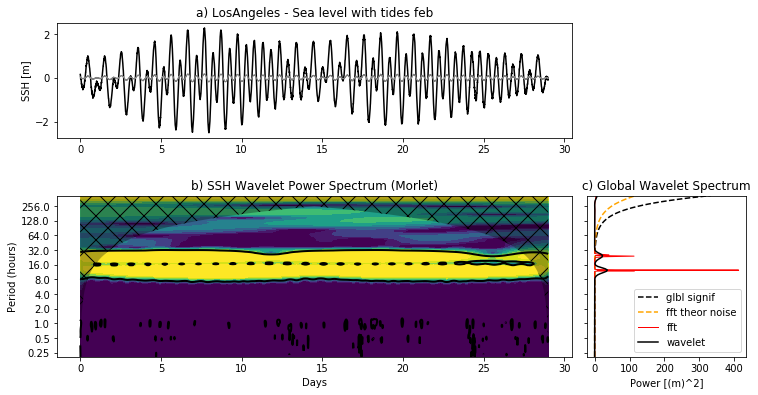

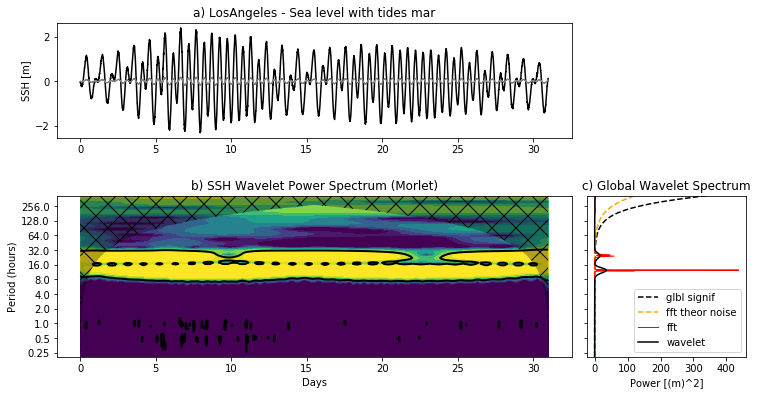

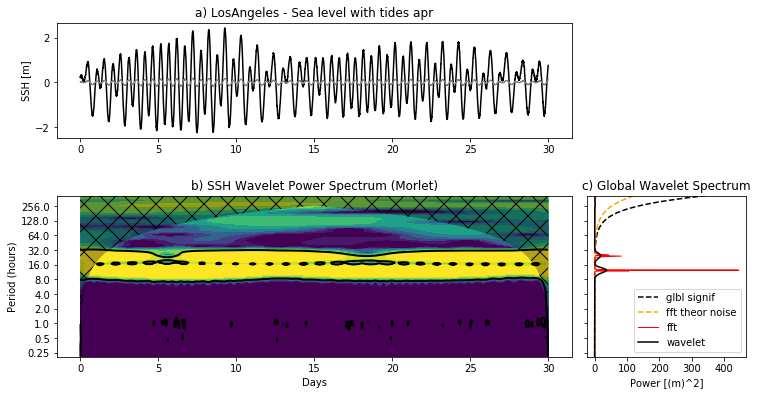

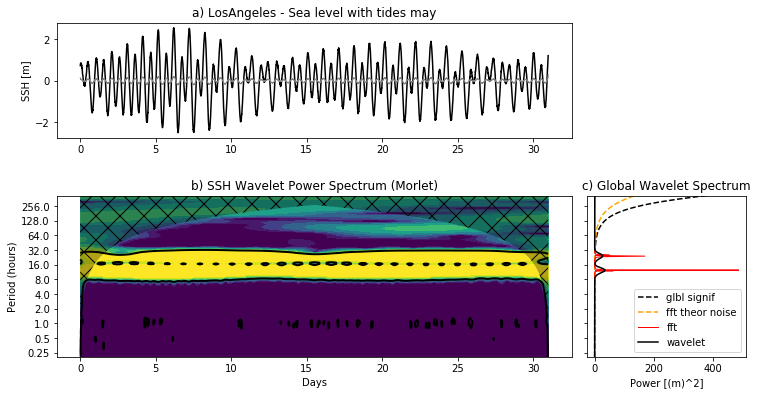

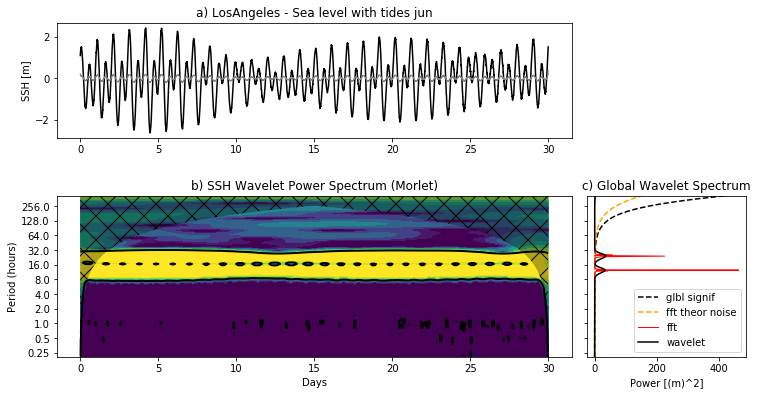

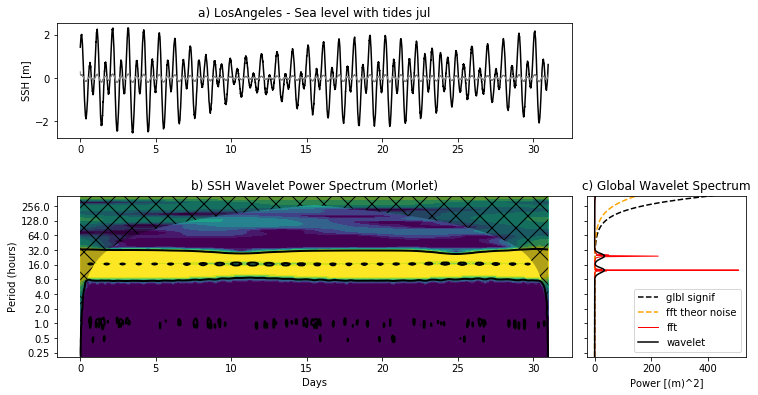

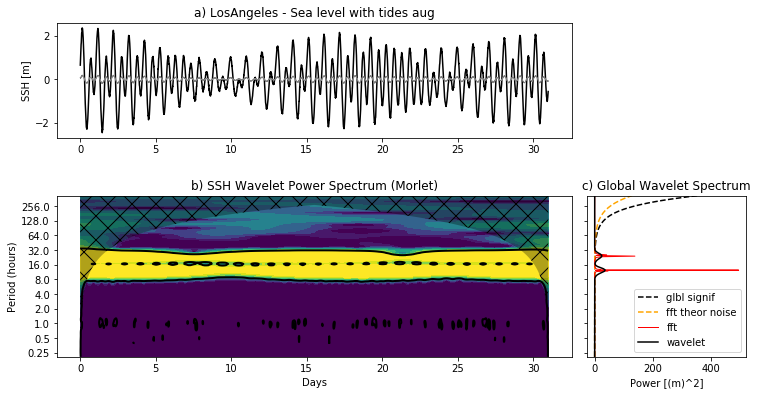

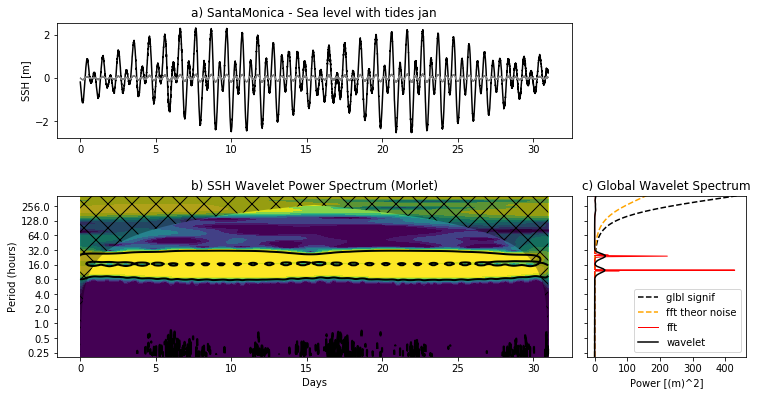

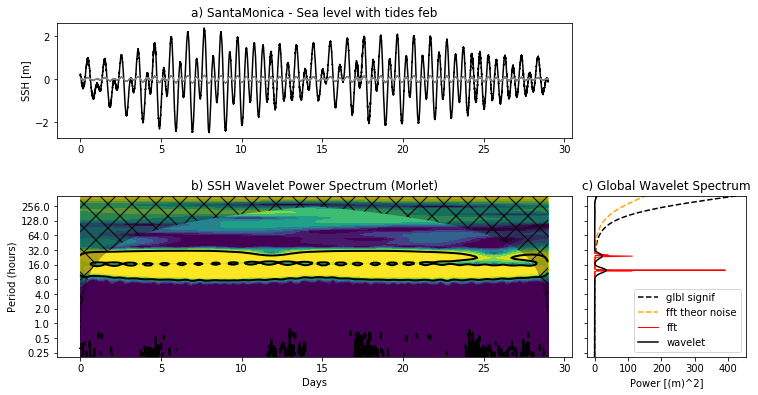

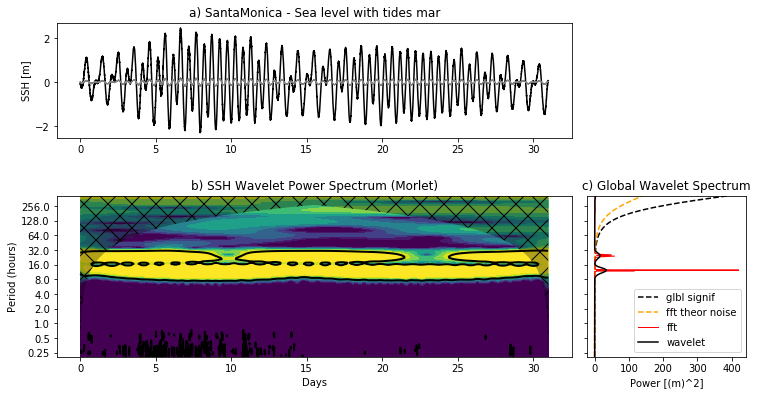

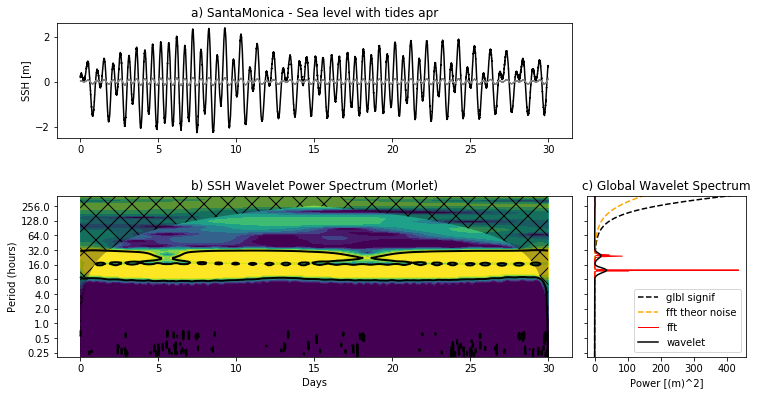

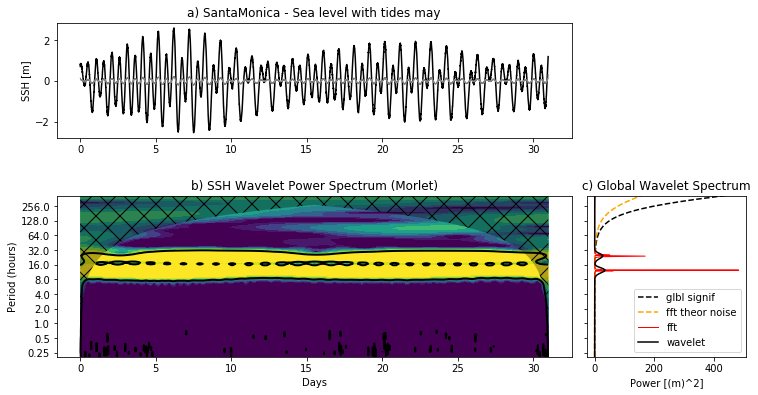

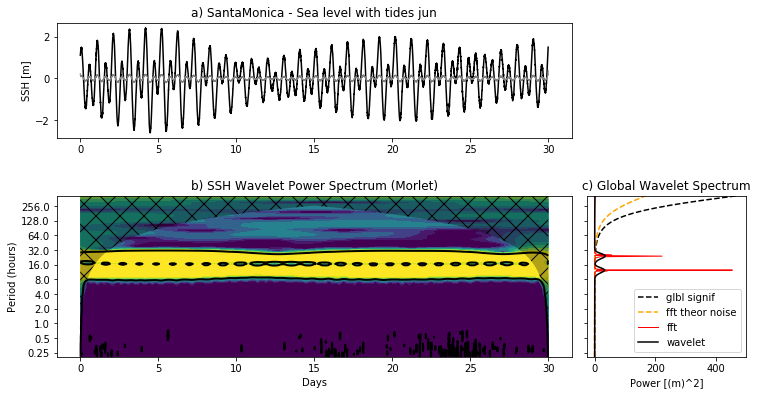

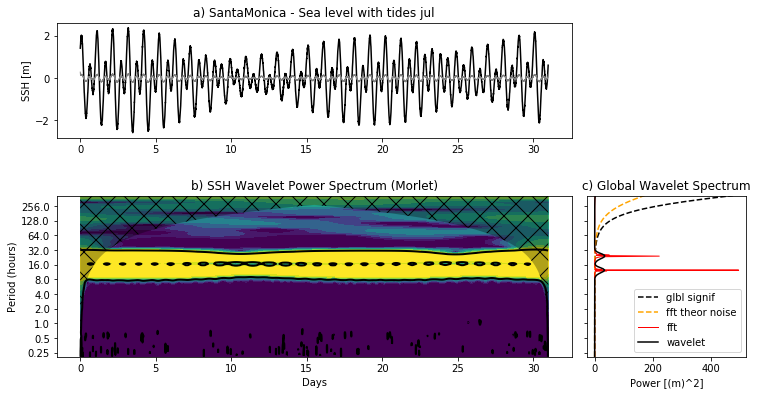

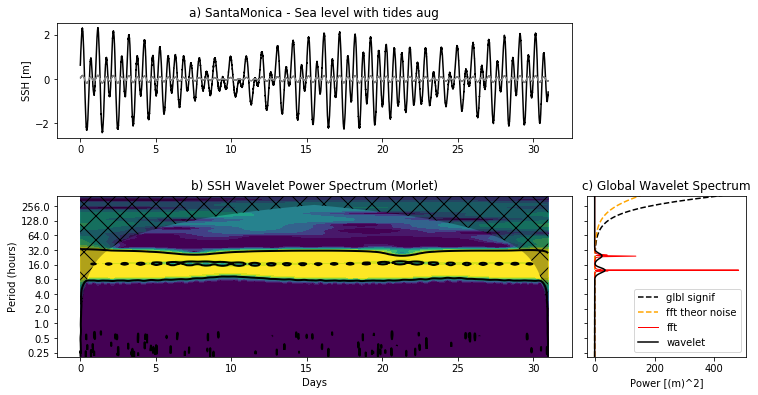

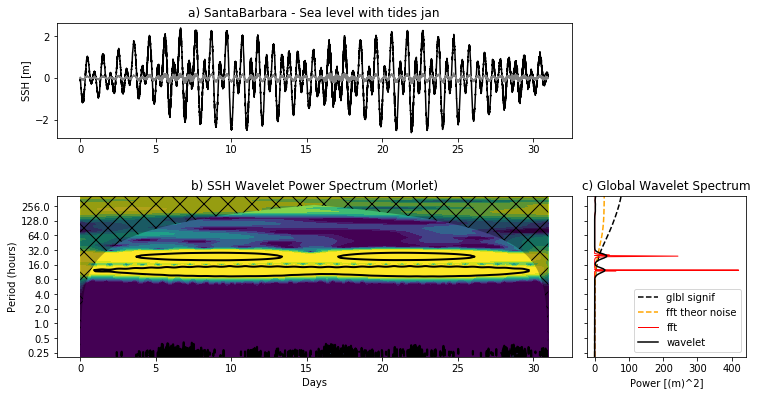

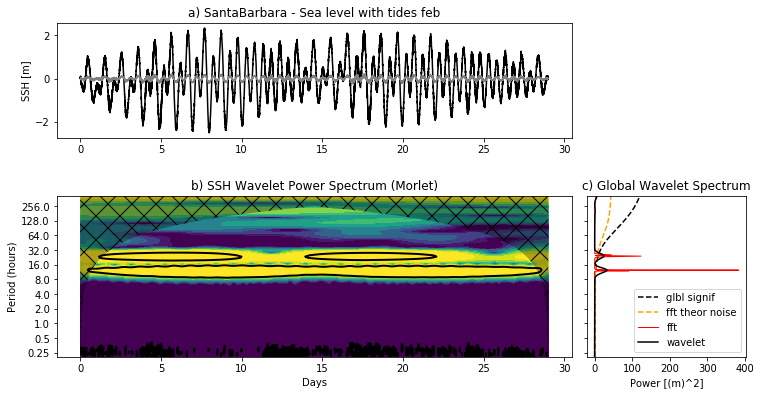

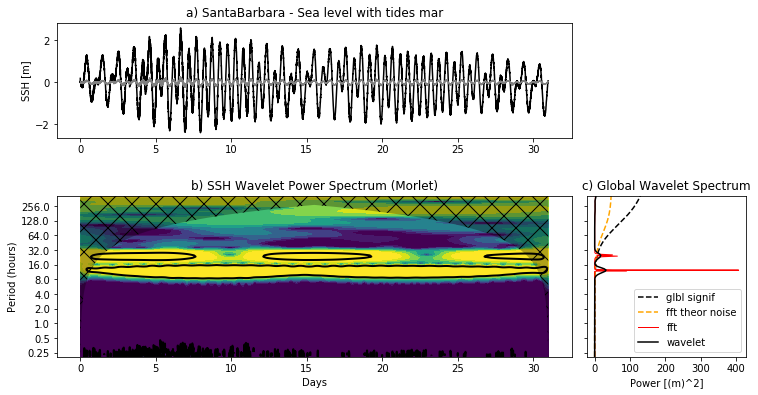

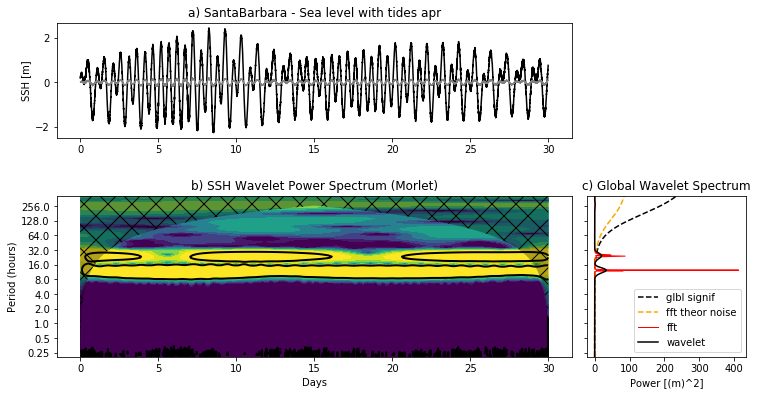

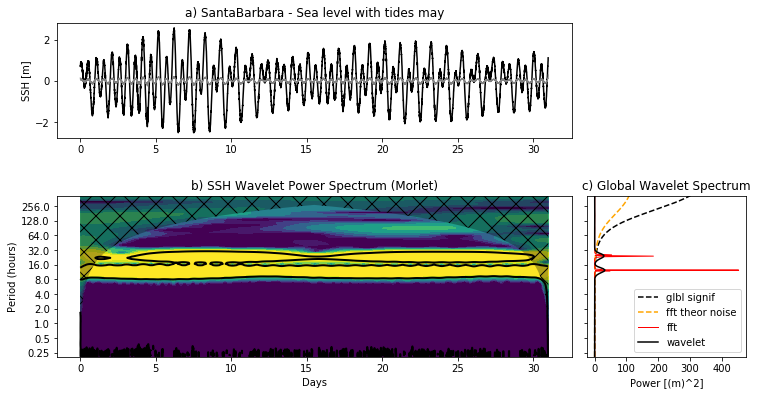

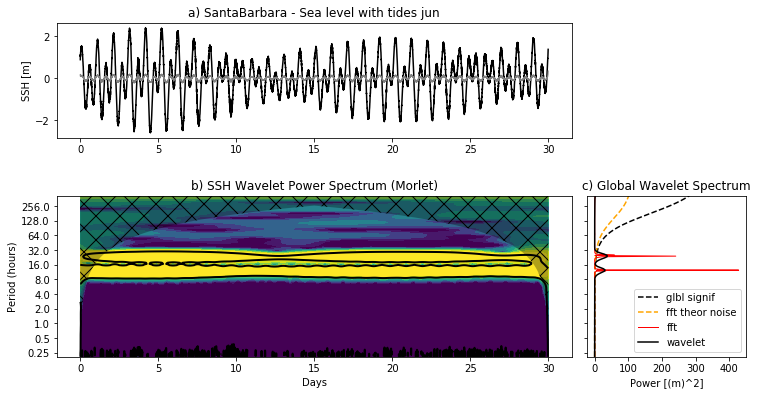

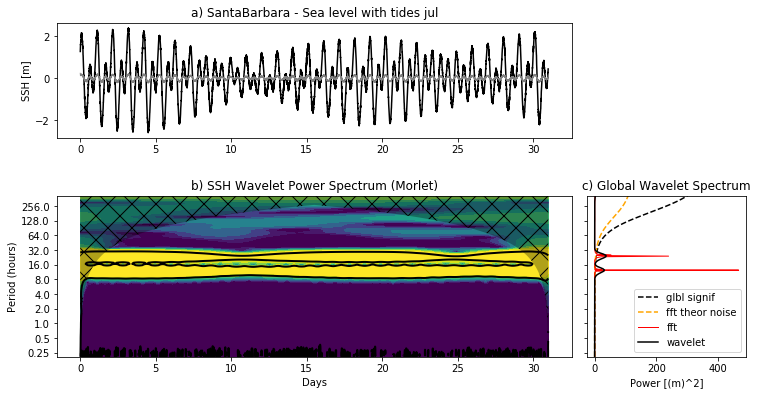

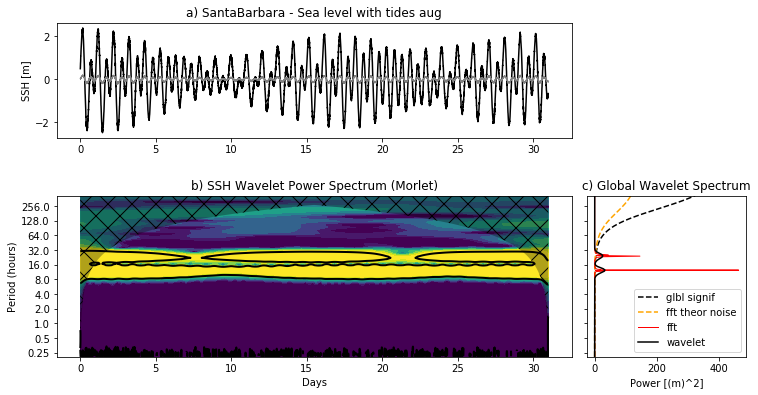

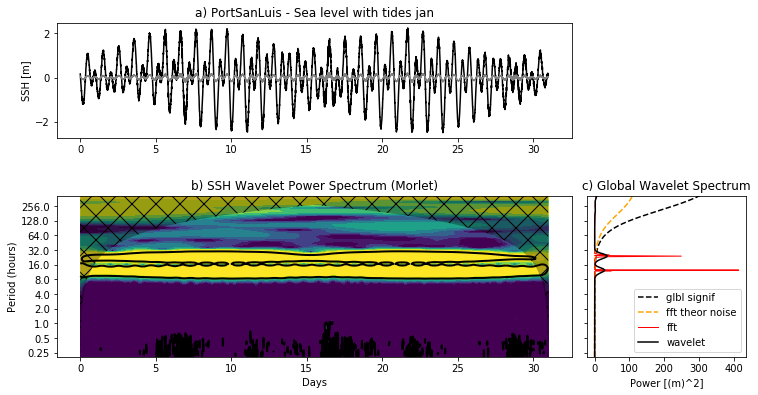

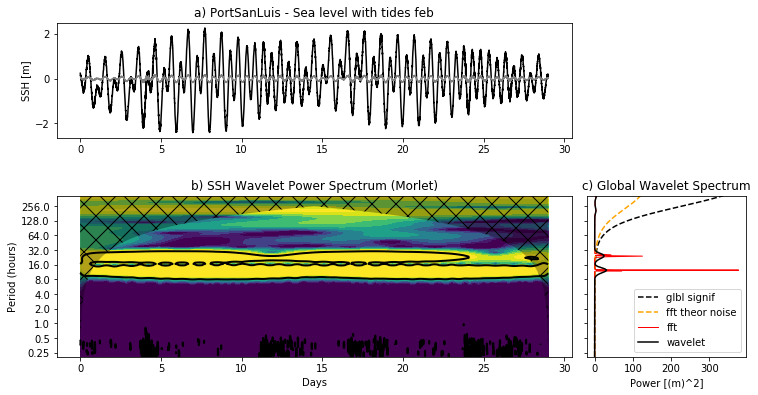

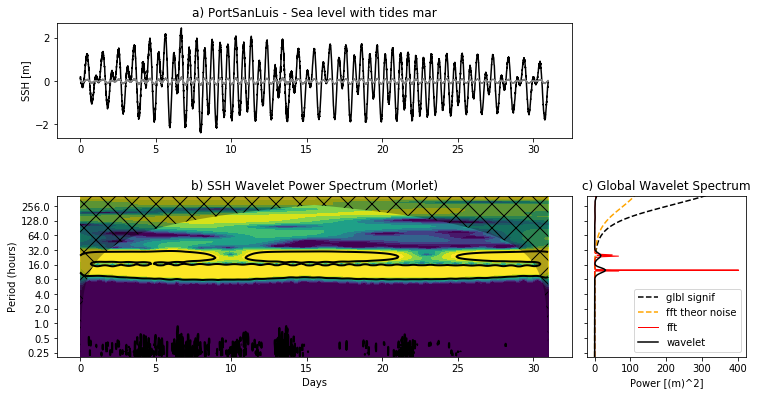

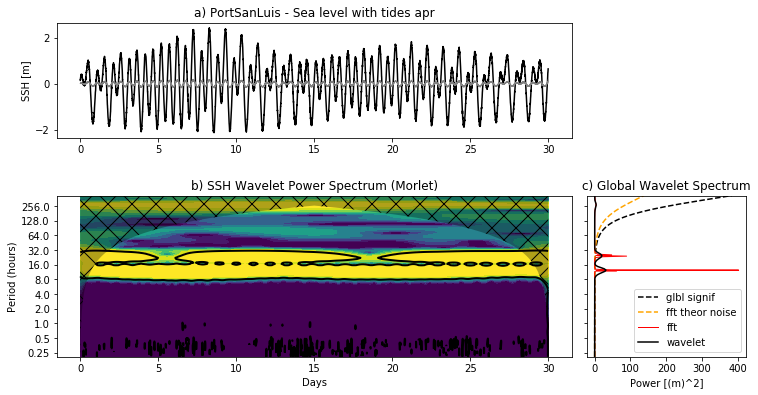

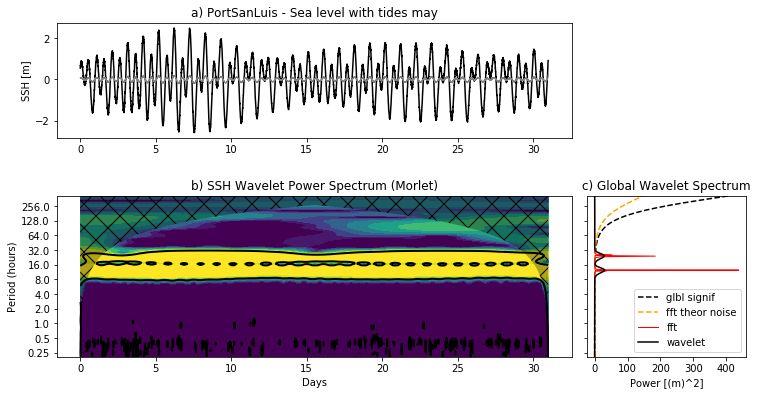

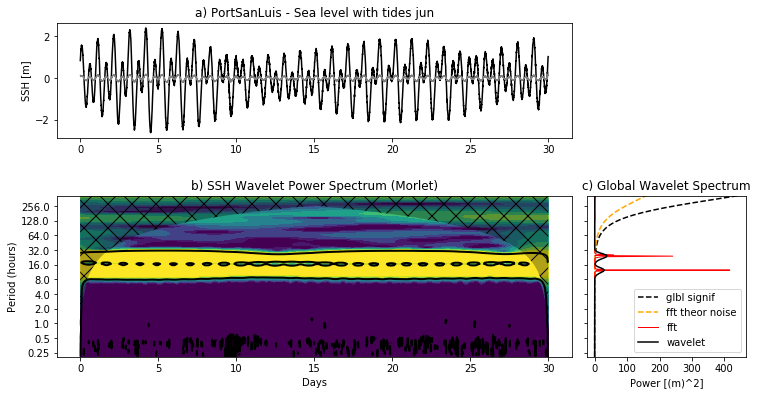

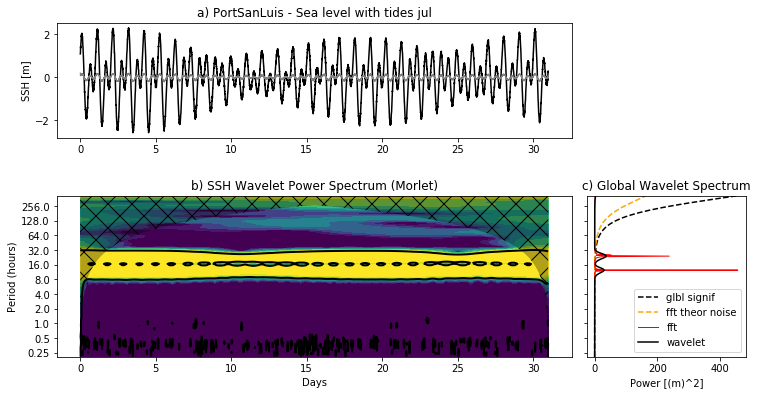

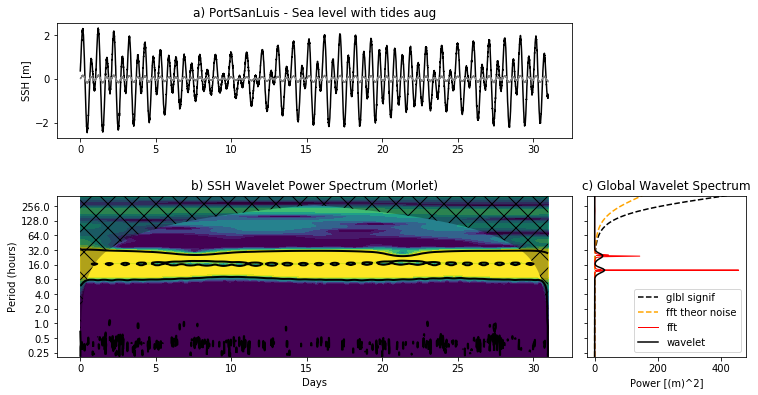

In [3]:
col_names = ["Date","Time","Predicted","Preliminary","Verified"]
stations=['LaJolla','LosAngeles','SantaMonica','SantaBarbara','PortSanLuis']
st_ids = ['9410230','9410660','9410840','9411340','9412110']
months = ['jan','feb','mar','apr','may','jun','jul','aug']
label = 'SSH'
units = 'm'
dt = 0.1  # in hours

for station, st_id in zip(stations, st_ids):
    for month in (months):
        title = '%s - Sea level with tides %s' %(station,month)

        # read data
        directory = '../NOAA-seaLevel/' + station 
        filename = directory + '/CO-OPS_' + st_id + '_met_' + month + '.csv'
        data = pd.read_csv(filename, parse_dates=[['Date', 'Time']], names=col_names) 
        data['datetime'] = pd.to_datetime(data['Date_Time'][1:], format='%Y/%m/%d %H:%M')
        data_new = data.set_index('datetime')
        ssh = pd.to_numeric(data_new['Verified'], errors='coerce')
 
        # Time vector of seconds (generate timedelta vector and convert to seconds)
        T = (data['datetime'][1:]-data['datetime'][1])/ np.timedelta64(1, 's')
        T[1] = 1
        
        t = (1/3600)*(T.copy())
        dat = ssh.values[1:]
        dat_notrend = dat - np.nanmean(dat)
        std = np.std(dat_notrend)
        var = std**2
        dat_norm = dat_notrend / std # Normalized dataset
        N = len(dat_norm)
        
        mother = wavelet.Morlet(6) 
        s0 = 2 * dt  # Starting scale, in this case 2 * 0.1 hr = 12 min
        dj = 1 / 12  # Twelve sub-octaves per octaves
        J = 11 / dj  # Eleven powers of two with dj sub-octaves
        alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise
    
        wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
        iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
        
        power = (np.abs(wave)) ** 2
        fft_power = np.abs(fft) ** 2
        period = 1 / freqs
        
        signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
        sig95 = np.ones([1, N]) * signif[:, None]
        sig95 = power / sig95

        glbl_power = power.mean(axis=1)
        dof = N - scales  # Correction for padding at edges
        glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                                significance_level=0.95, dof=dof,
                                                wavelet=mother)
        
        ## PLOT
        # Prepare the figure
        plt.close('all')
        plt.ioff()
        figprops = dict(figsize=(11, 8), dpi=72)
        fig = plt.figure(**figprops)

        # First sub-plot, the original time series anomaly and inverse wavelet
        # transform.
        ax = plt.axes([0.1, 0.75, 0.65, 0.2])
        ax.plot(t/(24), dat_norm, 'k', linewidth=1.5)
        ax.plot(t/(24), iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
        ax.set_title('a) {}'.format(title))
        ax.set_ylabel(r'{} [{}]'.format(label, units))

        # Second sub-plot, the normalized wavelet power spectrum and significance
        # level contour lines and cone of influece hatched area. Note that period
        # scale is logarithmic.
        bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
        levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
        bx.contourf(t/(24), np.log2(period), np.log2(power), np.log2(levels),
                    extend='both', cmap=plt.cm.viridis)
        extent = [t.min(), t.max(), 0, max(period)]
        bx.contour(t/(24), np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
                   extent=extent)
        bx.fill(np.concatenate([t/(24), t[-1:]/(24) + dt/(24), t[-1:]/(24) + dt/(24),
                                   t[:1]/(24) - dt/(24), t[:1]/(24) - dt/(24)]),
                np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                   np.log2(period[-1:]), [1e-9]]),
                'k', alpha=0.3, hatch='x')
        bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
        bx.set_ylabel('Period (hours)')
        #
        Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                   np.ceil(np.log2(period.max())))
        bx.set_yticks(np.log2(Yticks))
        bx.set_yticklabels(Yticks)
        bx.set_xlabel('Days')
        
        # Third sub-plot, the global wavelet and Fourier power spectra and theoretical
        # noise spectra. Note that period scale is logarithmic.
        cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
        cx.plot(glbl_signif, np.log2(period), 'k--', label='glbl signif')
        cx.plot(var * fft_theor, np.log2(period), '--', color='orange',label='fft theor noise')
        cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='red', label='fft',
                linewidth=1.)
        cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5, label = 'wavelet')
        cx.set_title('c) Global Wavelet Spectrum')
        cx.set_xlabel(r'Power [({})^2]'.format(units))
        #cx.set_xlim([0, glbl_power.max() + var])
        cx.set_ylim(np.log2([period.min(), period.max()]))
        cx.set_yticks(np.log2(Yticks))
        cx.set_yticklabels(Yticks)
        cx.legend()
        plt.setp(cx.get_yticklabels(), visible=False)

        plt.show()